In [9]:
##step1: collect the data
import numpy as np
from pathlib import Path
pathroot=Path('/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/')
subject = 'sub01'
modality = 'rest'

pathdata = pathroot/subject/modality
print(pathdata)

import glob
fmri_files = [];
confound_files = [];
for file in sorted(pathdata.glob('sess*/warped_F_sess*_res_ICA_filt_sm6.nii.gz')):
    fmri_files.append(str(file))

for confound in sorted(pathdata.glob('sess*/*.1D')):
    confound_files.append(str(confound))
    
print(fmri_files)
print(confound_files)

/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest
['/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess01/warped_F_sess01_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess02/warped_F_sess02_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess03/warped_F_sess03_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess04/warped_F_sess04_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess05/warped_F_sess05_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess06/warped_F_sess06_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess07/warped_F_sess07_res_ICA_filt_sm6.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/rest/sess08/warped_F_sess08_res_

/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz


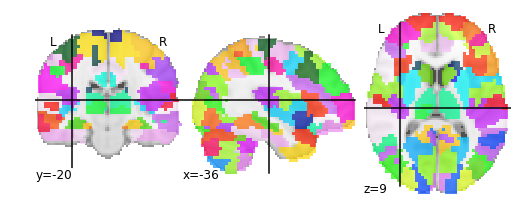

In [6]:
##step2: extract time series
##group atlas for all subjects/sessions
import matplotlib.pyplot as plt
from nilearn import plotting
%matplotlib inline

mist_atlas_file = "/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz"
print(mist_atlas_file)
plotting.plot_roi(mist_atlas_file)
TR = 2.2

from nilearn.image import mean_img, high_variance_confounds
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker

subjects_tc_matrix = [];
for fmri_file,confound_file in zip(fmri_files,confound_files):
    #fmri_file = fmri_files[0]
    #confound_file = confound_files[0]
    brain_masker = NiftiMasker(mask_strategy='epi')
    brain_masker.fit_transform(fmri_file)
    mean_fmri = mean_img(fmri_file)
    ##adjust group atlas to individual brain mask
    mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,mask_img=brain_masker.mask_img_,
                                  detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=TR)
    #plotting.plot_roi(mist_atlas.mask_img_,mean_fmri)
    highvar_confound = high_variance_confounds(fmri_file)
    mist_roi_tc = mist_atlas.fit_transform(fmri_file,confounds=[highvar_confound,confound_file])
    subjects_tc_matrix.append(mist_roi_tc)

In [7]:
#plotting.plot_matrix(gl.covariance_,cmap=plotting.cm.bwr,vmin=-1, vmax=1)
def find_parcel_coords(atlas_file,mask_img=False):
    #for 4D nifti image: atlas_region_coords = [plotting.find_xyz_cut_coords(img) for img in atlas_imgs]
    #this code for 3D atlas image
    import numpy as np
    import nibabel as nib
    from nilearn.plotting import find_xyz_cut_coords
    atlas = nib.load(atlas_file)
    atlas_img = atlas.get_data()
    labels = np.unique(atlas_img)

    atlas_coords=[]
    for li in labels[1:]:
        roi_data = np.array(atlas_img)
        roi_data[atlas_img != li ] = 0
        roi_data[atlas_img == li ] = 1
        #print(np.count_nonzero(roi_data))
        # create an image for the current roi
        roi_img = nib.Nifti1Image(dataobj=roi_data, affine=atlas.affine)
        if not mask_img:
            roi_center = find_xyz_cut_coords(roi_img)
        else:
            roi_center = find_xyz_cut_coords(roi_img,mask_img)
        #print(li,roi_center)
        atlas_coords.append(roi_center)

    return atlas_coords

#print(gsv.covariances_.shape)
mist_atlas_coords = find_parcel_coords(mist_atlas_file)
mist_atlas_coords_mask = find_parcel_coords(mist_atlas_file,brain_masker.mask_img_)

./mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
...[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished
.

[GraphLassoCV] Done refinement  1 out of 4:   1s


...[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s finished


[GraphLassoCV] Done refinement  2 out of 4:   4s


....[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s finished


[GraphLassoCV] Done refinement  3 out of 4:   9s


....[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


[GraphLassoCV] Done refinement  4 out of 4:  15s
[graph_lasso] Iteration   0, cost  inf, dual gap 2.098e+00
[graph_lasso] Iteration   1, cost  9.12e+02, dual gap 1.933e-01
[graph_lasso] Iteration   2, cost  9.12e+02, dual gap 7.006e-02
[graph_lasso] Iteration   3, cost  9.12e+02, dual gap 3.199e-02
[graph_lasso] Iteration   4, cost  9.12e+02, dual gap 1.452e-02
[graph_lasso] Iteration   5, cost  9.12e+02, dual gap 7.392e-03
[graph_lasso] Iteration   6, cost  9.12e+02, dual gap 3.718e-03
[graph_lasso] Iteration   7, cost  9.12e+02, dual gap 2.014e-03
[graph_lasso] Iteration   8, cost  9.12e+02, dual gap 8.707e-04
[graph_lasso] Iteration   9, cost  9.12e+02, dual gap 4.930e-04
[graph_lasso] Iteration  10, cost  9.12e+02, dual gap 1.320e-04
[graph_lasso] Iteration  11, cost  9.12e+02, dual gap -4.152e-05


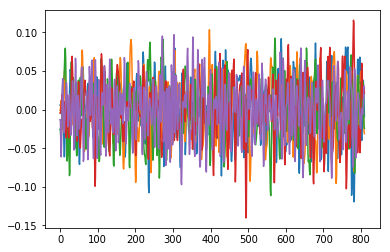

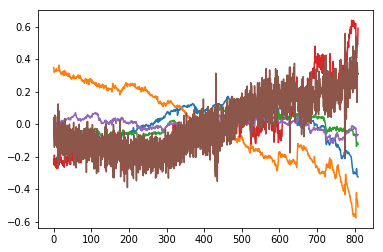

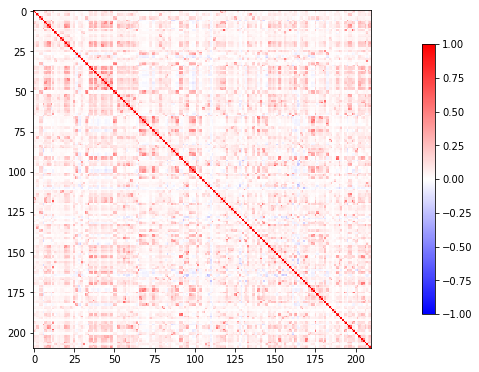

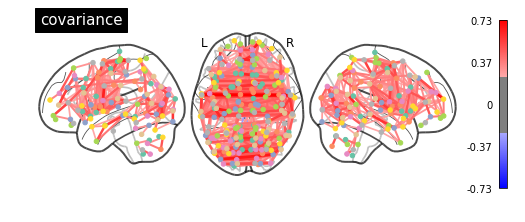

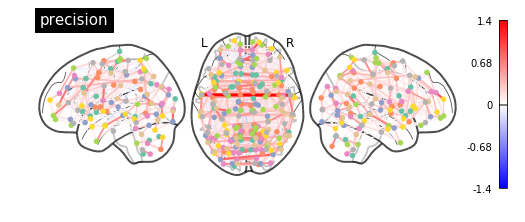

In [13]:
##step3: collect confounds for calculating connectivity
from nilearn.image import high_variance_confounds
head_motion = np.loadtxt(confound_file)
highvar_confound = high_variance_confounds(fmri_file)
plt.plot(highvar_confound)
plt.figure()
plt.plot(head_motion)

###step4: calculate connectivity
from sklearn.covariance import GraphLassoCV
gl = GraphLassoCV(verbose=2)
gl.fit(np.concatenate(subjects_tc_matrix))
plotting.plot_matrix(gl.covariance_,cmap=plotting.cm.bwr,vmin=-1, vmax=1)
plotting.plot_connectome(gl.covariance_,mist_atlas_coords,display_mode="lzr",title='covariance',colorbar=True,
                         edge_threshold="95%",node_size=20)
plotting.plot_connectome(-gl.precision_,mist_atlas_coords,display_mode="lzr",title='precision',colorbar=True,
                        edge_threshold="95%",node_size=20)

In [52]:
##step5: individual connectivity matrix links to task activation
from pathlib import Path
import glob
pathroot=Path('/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/')
subject = 'sub01'
modality = 'motor' #'rest'
postfix = '_ICA'
resolution = '' #'_3mm'
task_contrasts = {1: "foot",
                  2: "hand",
                  3: "tongue",
                  4: "foot_left",
                  5: "foot_right",
                  6: "hand_left",
                  7: "hand_right"}

pathdata = pathroot/subject/modality
print(pathdata)

task_activity_files = [];
for file in sorted(pathdata.glob('sess*/run*/zstats'+postfix+'_merged'+resolution+'.nii.gz')):
    task_activity_files.append(str(file))

brain_mask_files = [];
for file in sorted(pathdata.glob('sess*/run*/brain_mask.nii.gz')):
    brain_mask_files.append(str(file))

print(task_activity_files)
#print(brain_mask_files)
print(len(task_activity_files))

/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor
['/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess01/run1/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess01/run2/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess02/run1/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess02/run2/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess03/run1/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess03/run2/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess04/run1/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess04/run2/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/pr

(7, 210)
20


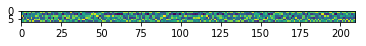

In [348]:
##step6: extract brain activation during task performance
mist_atlas_file = "/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz"
##loading atlas region information
import pandas as pd
df1=pd.read_csv("/data/cisl/raw_data/midnight/MIST_atlas/Parcel_Information/MIST_ROI.csv",
               sep=';', encoding="utf8",  error_bad_lines=False)
Region_ids = np.array(df1.roi)
Region_names = np.array(df1.name)

from nilearn.image import high_variance_confounds
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker

###extract brain activity from task data
subjects_activity_matrix = [];
for activity_file,mask_file in zip(task_activity_files,brain_mask_files):
    #fmri_file = fmri_files[0]
    ##adjust group atlas to individual brain mask
    mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,
                                  detrend=True, standardize=True)
    mist_roi_act = mist_atlas.fit_transform(activity_file)
    subjects_activity_matrix.append(mist_roi_act)

plt.imshow(subjects_activity_matrix[0])
print(subjects_activity_matrix[0].shape)
print(len(subjects_activity_matrix))

In [79]:
def dynamic_fc_matrix(subject_tc_matrix,window_size=140,step_size=5,cov_method=1):
    ##generating more training samples using sliding-window
    ##subject_tc_matrix: time*region signals
    TIMEPOINTS = subject_tc_matrix.shape[0]

    from sklearn.covariance import GraphLassoCV,MinCovDet
    if cov_method == 1:
        gl = GraphLassoCV()
    elif cov_method == 2:
        gl = MinCovDet()

    fc_matrix_set = [];
    for ti in np.arange(0,TIMEPOINTS-window_size+1,step_size):
        tc_matrix = subjects_tc_matrix[0][ti:ti+window_size,:]
        gl.fit(tc_matrix)
        fc_matrix_set.append(gl.covariance_)
    
    print(np.array(fc_matrix_set).shape)
    return fc_matrix_set

In [241]:
##collect the training data
Subjects = len(subjects_tc_matrix)
RegionsNum = 210
subjects_fc_matrix = []
subjects_act_matrix = []
task_id = 1
for subj in np.arange(Subjects):
    fc_matrix = dynamic_fc_matrix(subjects_tc_matrix[subj],window_size=280,cov_method=2)
    fc_matrix_1d = [fc[np.triu_indices(RegionsNum,1)] for fc in fc_matrix ]
    act_matrix = np.column_stack((subjects_activity_matrix[subj*2][task_id,],subjects_activity_matrix[subj*2+1][task_id,])).T
    subject_data = (list(itertools.product(fc_matrix_1d,list(act_matrix))))
    #print(len(subject_data))
    
    fc_matrix_data = [fc[0] for fc in subject_data ]
    act_matrix_data = [fc[1] for fc in subject_data ]
    subjects_fc_matrix.append(np.array(fc_matrix_data))
    subjects_act_matrix.append(np.array(act_matrix_data))

print(np.array(subjects_fc_matrix).shape)
print(np.array(subjects_act_matrix).shape)


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


(107, 210, 210)
(107, 210, 210)
(107, 210, 210)
(107, 210, 210)
(107, 210, 210)
(107, 210, 210)
(107, 210, 210)
(107, 210, 210)
(107, 210, 210)
(107, 210, 210)
(10, 214, 21945)
(10, 214, 210)


In [426]:
def linear_regression_models(fc_data,act_data,estimators,my_testsize=0.4,my_cv=10,my_score='neg_mean_squared_error'):
    ##fc_data: functional connectivity matrix as vectors
    ##act_data: brain activation data in one region
    ##estimators: name and linear_model.method
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split( fc_data, act_data,test_size=my_testsize, random_state=10)
    
    
    scores_cv = []
    coefs_est = []
    for name, estimator in estimators:
        model =  estimator
        scores = cross_val_score(model, fc_data, act_data, cv=my_cv,scoring=my_score)
        scores_cv.append(np.mean(scores))

        model.fit(X_train, Y_train)
        coefs_est.append(model.coef_)
        mse = metrics.mean_squared_error(model.predict(X_test), Y_test)
        r2score = metrics.r2_score(model.predict(X_test), Y_test)
        print("Linear Mode: %s, with mean %s score in cv: %4f" % (name,my_score,np.mean(scores)))
        print("-----Score on Test data: MSE: %4f, R2: %4f ----" % (mse,r2score))
        print('')
        
    return scores_cv, coefs_est



In [427]:
##step7: training models for prediction: one linear model per region
RegionsNum = subjects_act_matrix[0].shape[1]
#region_id = 10;
z_thre = 1.85

fc_data = np.vstack(subjects_fc_matrix)
act_data = np.vstack(subjects_act_matrix)
regions_set = np.nonzero(np.logical_and(np.std(act_data,axis=0)>1e-4,np.amax(np.absolute(act_data),axis=0)>z_thre))
print(len(regions_set[0]))
#print(Region_names[regions_set])
#print(fc_data.shape)
#print(act_data.shape)

from sklearn import linear_model, svm, metrics
my_estimators = [('OLS', linear_model.LinearRegression()),
                 ('ridge_cv', linear_model.RidgeCV(alphas=[50, 10, 5,1, 0.1,0.01],cv=5)),
                 ('lasso_cv', linear_model.LassoCV(alphas=[5, 1, 0.5,0.1,0.05],cv=10)),
                 ('enet_cv', linear_model.ElasticNetCV(alphas=[5, 2,1, 0.5,0.2, 0.1,0.05], l1_ratio=0.05, cv=10)),                 
                 ('svr', svm.LinearSVR(random_state=10, C=0.01))]

model_best_scores = []
for region_id in regions_set[0]:
    print("Start analysis for region# %d: %s" % (Region_ids[region_id],Region_names[region_id]))
    
    scores_cv, model_coefs = linear_regression_models(fc_data,act_data[:,region_id],my_estimators)
    
    method_id = np.argmax(scores_cv) 
    print("The Best Linear Method %s with MSE score: %4f" % (my_estimators[method_id][0],-scores_cv[method_id]))
    model_best_scores.append(scores_cv[method_id])
    
    upper_matrix=(model_coefs[method_id])
    idx = np.argsort(np.absolute(upper_matrix))[-10:] #np.nonzero(np.absolute(upper)>1e-2) #np.argmax(upper)
    row, col = np.unravel_index(idx, (RegionsNum,RegionsNum))
    print("Maximum coefficient is: %4f" % np.max(np.absolute(upper_matrix)))
    print("Top 10 Functional Connectivity are: ")
    for ii in np.arange(10):
        print(" ---------%s\t:\t%s \t%4f" % (Region_names[row[ii]],Region_names[col[ii]],upper_matrix[idx[ii]]))
    print('')
    print('')




48
Start analysis for region# 3: right_CAUDATE_ventral
Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -5207398673545131008.000000
-----Score on Test data: MSE: 12438444797053680.000000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -0.728653
-----Score on Test data: MSE: 0.672944, R2: -14.397661 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.680311
-----Score on Test data: MSE: 0.625060, R2: -50710890440238676918826512154624.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.680311
-----Score on Test data: MSE: 0.625060, R2: -50710890440238676918826512154624.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.725086
-----Score on Test data: MSE: 0.665565, R2: -18.559975 ----

The Best Linear Method lasso_cv with MSE score: 0.680311
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -228397940656068132864.000000
-----Score on Test data: MSE: 2982901714264030.500000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -0.731653
-----Score on Test data: MSE: 0.677035, R2: -13.189007 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.697992
-----Score on Test data: MSE: 0.610043, R2: 0.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.697992
-----Score on Test data: MSE: 0.610043, R2: 0.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.762505
-----Score on Test data: MSE: 0.710013, R2: -11.181271 ----

The Best Linear Method lasso_cv with MSE score: 0.697992
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_left_POSTCENTRAL_SULCUS 	-0.0

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -34274757344365731840.000000
-----Score on Test data: MSE: 4743399328100982.000000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -0.858351
-----Score on Test data: MSE: 0.786130, R2: -15.234493 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.805491
-----Score on Test data: MSE: 0.737096, R2: -239201365160133106816096229392384.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.805491
-----Score on Test data: MSE: 0.737096, R2: -239201365160133106816096229392384.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.923782
-----Score on Test data: MSE: 0.838112, R2: -11.916057 ----

The Best Linear Method lasso_cv with MSE score: 0.805491
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 --------

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -583268951505846528.000000
-----Score on Test data: MSE: 1639835805219368.000000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -1.063084
-----Score on Test data: MSE: 0.958507, R2: -14.377128 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.990213
-----Score on Test data: MSE: 0.881137, R2: -1143781622647519655281035548033024.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.990213
-----Score on Test data: MSE: 0.881137, R2: -1143781622647519655281035548033024.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.953868
-----Score on Test data: MSE: 0.899648, R2: -29.739560 ----

The Best Linear Method svr with MSE score: 0.953868
Maximum coefficient is: 0.017325
Top 10 Functional Connectivity are: 
 ---------left_PRECUNEUS_dorsal	:	left_PARIETO_OCCIPITAL_SULCUS 	0.014981
 ---------left_PERI_

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -282366643727283904.000000
-----Score on Test data: MSE: 3005823348546882.500000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -0.105795
-----Score on Test data: MSE: 0.102621, R2: -18.149150 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.101782
-----Score on Test data: MSE: 0.093723, R2: -1900927044066419453965239320576.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.101782
-----Score on Test data: MSE: 0.093723, R2: -1900927044066419453965239320576.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.111924
-----Score on Test data: MSE: 0.109849, R2: -11.398624 ----

The Best Linear Method lasso_cv with MSE score: 0.101782
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 ---------right

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -1.328209
-----Score on Test data: MSE: 1.157533, R2: -667806023794316894378046512955392.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -1.426017
-----Score on Test data: MSE: 1.261875, R2: -12.929744 ----

The Best Linear Method lasso_cv with MSE score: 1.328209
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_left_POSTCENTRAL_SULCUS 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_VENTRAL_VISUAL_NETWORK_lateral 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_VENTRAL_VISUAL_NETWORK_lateral 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_DORSAL_VISUAL_STREAM_ventrolateral 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_DORSAL_VISUAL_STREAM_ventrolateral 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_HESCHLS GYRU

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -6167365753218053120.000000
-----Score on Test data: MSE: 63377204821749168.000000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -0.354777
-----Score on Test data: MSE: 0.363954, R2: -14.815452 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.336632
-----Score on Test data: MSE: 0.312995, R2: -6348295685660622889015259955200.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.336632
-----Score on Test data: MSE: 0.312995, R2: -6348295685660622889015259955200.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.370517
-----Score on Test data: MSE: 0.369242, R2: -22.891154 ----

The Best Linear Method lasso_cv with MSE score: 0.336632
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 ---------rig

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -26094684109814960128.000000
-----Score on Test data: MSE: 38780727332233816.000000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -1.291635
-----Score on Test data: MSE: 1.119527, R2: -12.480119 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -1.178030
-----Score on Test data: MSE: 1.067740, R2: -38500176912431121222835298631680.000000 ----



/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -1.178030
-----Score on Test data: MSE: 1.067740, R2: -38500176912431121222835298631680.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -1.268520
-----Score on Test data: MSE: 1.113653, R2: -15.295171 ----

The Best Linear Method lasso_cv with MSE score: 1.178030
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_left_POSTCENTRAL_SULCUS 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_VENTRAL_VISUAL_NETWORK_lateral 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_VENTRAL_VISUAL_NETWORK_lateral 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_DORSAL_VISUAL_STREAM_ventrolateral 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_DORSAL_VISUAL_STREAM_ventrolateral 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_HESCHLS GYRUS 

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -95637855970624144.000000
-----Score on Test data: MSE: 30951348119617308.000000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -0.205221
-----Score on Test data: MSE: 0.194265, R2: -12.642369 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.194210
-----Score on Test data: MSE: 0.174840, R2: -3546169467050562594189864861696.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.194210
-----Score on Test data: MSE: 0.174840, R2: -3546169467050562594189864861696.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.237322
-----Score on Test data: MSE: 0.206558, R2: -6.476064 ----

The Best Linear Method lasso_cv with MSE score: 0.194210
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 ---------right_

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -26149350446451273728.000000
-----Score on Test data: MSE: 25259543047501172.000000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -0.888981
-----Score on Test data: MSE: 0.744731, R2: -9.962382 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.824096
-----Score on Test data: MSE: 0.717340, R2: -232790089460499418563640293326848.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.824096
-----Score on Test data: MSE: 0.717340, R2: -232790089460499418563640293326848.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.873412
-----Score on Test data: MSE: 0.739643, R2: -13.406313 ----

The Best Linear Method lasso_cv with MSE score: 0.824096
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 --------

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -1.521276
-----Score on Test data: MSE: 1.333489, R2: -108185490015924055757656105680896.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -1.718576
-----Score on Test data: MSE: 1.419879, R2: -10.545095 ----

The Best Linear Method lasso_cv with MSE score: 1.521276
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_left_POSTCENTRAL_SULCUS 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_VENTRAL_VISUAL_NETWORK_lateral 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_VENTRAL_VISUAL_NETWORK_lateral 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_DORSAL_VISUAL_STREAM_ventrolateral 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_DORSAL_VISUAL_STREAM_ventrolateral 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_HESCHLS GYR

Linear Mode: OLS, with mean neg_mean_squared_error score in cv: -4964491775187594240.000000
-----Score on Test data: MSE: 3798932461532939.000000, R2: -0.003653 ----

Linear Mode: ridge_cv, with mean neg_mean_squared_error score in cv: -0.616702
-----Score on Test data: MSE: 0.527537, R2: -14.709432 ----

Linear Mode: lasso_cv, with mean neg_mean_squared_error score in cv: -0.566100
-----Score on Test data: MSE: 0.494187, R2: -10023298549932200924065128513536.000000 ----

Linear Mode: enet_cv, with mean neg_mean_squared_error score in cv: -0.566100
-----Score on Test data: MSE: 0.494187, R2: -10023298549932200924065128513536.000000 ----

Linear Mode: svr, with mean neg_mean_squared_error score in cv: -0.657772
-----Score on Test data: MSE: 0.582698, R2: -17.144276 ----

The Best Linear Method lasso_cv with MSE score: 0.566100
Maximum coefficient is: 0.000000
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	-0.000000
 ---------ri

In [424]:
print(np.array(model_coefs).shape)
print(scores_cv)
method_id = np.argmax(scores_cv)
print("The best method is %s with MSE score: %4f" % (my_estimators[method_id][0],scores_cv[method_id]))
model_best_scores.append(scores_cv[method_id])

print(my_estimators[1][0])
print(model_best_scores)

upper_matrix=(model_coefs[method_id])
idx = np.argsort(np.absolute(upper_matrix))[-10:] #np.nonzero(np.absolute(upper)>1e-2) #np.argmax(upper)
row, col = np.unravel_index(idx, (RegionsNum,RegionsNum))
print("Top 10 Functional Connectivity are: ")
for ii in np.arange(10):
    print(" ---------%s\t:\t%s \t%4f" % (Region_names[row[ii]],Region_names[col[ii]],upper_matrix[idx[ii]]))

print(np.sort(np.absolute(upper_matrix))[-1:])
print(np.max(np.absolute(upper_matrix)))

(5, 21945)
[-2.0013674883885724e+19, -0.6900038142220829, -0.64627979230850141, -0.64627979230850141, -0.69798404701976235]
The best method is lasso_cv with MSE score: -0.646280
ridge_cv
[-0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141, -0.64627979230850141]
Top 10 Functional Connectivity are: 
 ---------right_INTRAPARIETAL_SULCUS	:	left_PARIETO_OCCIPITAL_SULCUS 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_left_POSTCENTRAL_SULCUS 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_VENTRAL_VISUAL_NETWORK_lateral 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_VENTRAL_VISUAL_NETWORK_lateral 	-0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	left_DORSAL_VISUAL_STREAM_ventrolateral 	0.000000
 ---------right_INTRAPARIETAL_SULCUS	:	right_DORSAL_VISUAL_STREAM_ventrolateral 	-0.000000
 

In [444]:
##testing code
RegionsNum = 210
region_id = 10;
tmp=np.vstack(subjects_fc_matrix[1][np.triu_indices(RegionsNum,1)])
tmp=[fc[np.triu_indices(RegionsNum,1)] for fc in subjects_fc_matrix ]
print(np.array(tmp).shape)
tmp2=np.column_stack((subjects_activity_matrix[1*2][1,],subjects_activity_matrix[1*2+1][1,])).T


import itertools
subject_data=(list(itertools.product(tmp,list(tmp2))))
fc_data = np.array([fc[0] for fc in subject_data ])
act_data = np.array([fc[1] for fc in subject_data ])
print(fc_data.shape)
print(act_data.shape)
X_train = fc_data[:10,]; 
X_test = fc_data[10:,];
Y_train = act_data[:10,region_id];
Y_test = act_data[10:,region_id];

from sklearn import linear_model, svm, metrics
estimators = [('OLS', linear_model.LinearRegression()),
              ('enet_cv', linear_model.ElasticNetCV(alphas=[5, 1, 0.5, 0.1],l1_ratio=0.05)),
              ('ridge_cv', linear_model.RidgeCV(alphas=[100, 10, 1, 0.1])),
              ('svr', svm.SVR(kernel='linear', C=0.001))]

x_plot = np.linspace(fc_data.min(), fc_data.max())
for name, estimator in estimators:
    model =  estimator
    model.fit(X_train, Y_train)
    mse = metrics.mean_squared_error(model.predict(X_test), Y_test)
    score = model.score(X_test, Y_test)
    coefs = model.coef_
    print(name,mse)
    #y_plot = model.predict(x_plot[:, np.newaxis])
    #plt.plot(x_plot, y_plot, label='%s: error = %.3f' % (name, mse))

(10, 21945)
(20, 21945)
(20, 210)
OLS 1.26015727493e+24
enet_cv 0.00576104823692
ridge_cv 0.00576104823692
svr 0.00576104823692


(5, 21945)
(array([    1,     2,     3, ..., 21942, 21943, 21944]),)
Maximum coefficient is: 0.018491
Top 10 Functional Connectivity are: 
 ---------right_LATERAL_VISUAL_NETWORK_dorsoposterior	:	left_SOMATOMOTOR_NETWORK_dorsolateral 	0.015753
 ---------left_CEREBELLUM_VERMIS	:	left_INFERIOR_PARIETAL_LOBULE 	0.015783
 ---------right_PUTAMEN_anterior	:	left_ANTERIOR_INSULA_ventral 	0.015849
 ---------left_POSTERIOR_CINGULATE_CORTEX	:	right_PRECUNEUS_ventral 	0.016118
 ---------left_NOISE	:	right_ANTERIOR_INSULA_ventral 	-0.016493
 ---------left_MEDIAL_VISUAL_NETWORK_anteroventral	:	right_DORSOMEDIAL_PREFRONTAL_CORTEX_anterocaudal 	0.016666
 ---------right_FUSIFORM_GYRUS_ventrolateral	:	right_ANTERIOR_CINGULATE_CORTEX_dorsal 	0.016741
 ---------right_DORSOMEDIAL_PREFRONTAL_CORTEX_anterocaudal	:	right_ANTERIOR_INSULA_anteroodorsal 	0.016754
 ---------left_THALAMUS_ventral	:	left_VENTRAL_VISUAL_NETWORK_lateral 	-0.016930
 ---------left_POSTERIOR_VISUAL_NETWORK_lateral	:	right_PERI_INSULAR_S

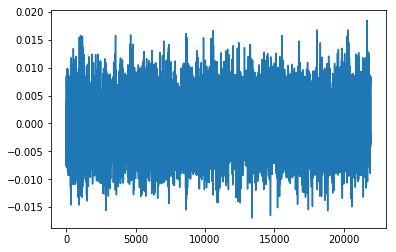

In [438]:
method_id = 4
print(np.array(model_coefs).shape)
print(np.nonzero(model_coefs[method_id]>1e-4))
plt.plot(model_coefs[method_id])

upper_matrix=(model_coefs[method_id])
idx = np.argsort(np.absolute(upper_matrix))[-10:] #np.nonzero(np.absolute(upper)>1e-2) #np.argmax(upper)
row, col = np.unravel_index(idx, (RegionsNum,RegionsNum))
print("Maximum coefficient is: %4f" % np.max(np.absolute(upper_matrix)))
print("Top 10 Functional Connectivity are: ")
for ii in np.arange(10):
    print(" ---------%s\t:\t%s \t%4f" % (Region_names[row[ii]],Region_names[col[ii]],upper_matrix[idx[ii]]))
